# Manual QPE construction for Mock qDrift

In [26]:
import numpy as np
import scipy
import math
from scripts.algo.chebyshev import chebyshev_nodes, chebyshev_barycentric_interp
import matplotlib.pyplot as plt

In [27]:
U = 5
t = 2
a = U + t
time = 1
N = 5000
hubbard = np.array([[U, -t], [-t, U]])
nodes = chebyshev_nodes(20)[:10]
print(nodes)

[0.996917333733128, 0.9723699203976766, 0.9238795325112867, 0.8526401643540923, 0.7604059656000309, 0.6494480483301835, 0.5224985647159489, 0.38268343236508984, 0.23344536385590547, 0.078459095727845]


In [28]:
num_op = np.array([[1, 0], [0, 1]])

In [29]:
scipy.linalg.expm(1j*np.array([[1, 0], [0, np.pi/4]]))

array([[0.54030231+0.84147098j, 0.        +0.j        ],
       [0.        +0.j        , 0.70710678+0.70710678j]])

In [30]:
u_term = scipy.linalg.expm((1j * a * time / N) * np.array([[1, 0], [0, 1]]))
t_term = scipy.linalg.expm((1j * a * time / N) * np.array([[0, -1], [-1, 0]]))

In [31]:
print(u_term)

[[0.99999902+0.0014j 0.        +0.j    ]
 [0.        +0.j     0.99999902+0.0014j]]


In [32]:
def phase_estimation(unitary, negative: bool):
    """
    Quantum phase estimation
    Args:
        unitary: The unitary to use
        negative: if True, we assume the phase is negative and apply -2pi 
    Returns: The phase of the unitary operator

    """
    # Initial state  |00>
    init_state = np.matrix([1, 0, 0, 0]).T
    
    # Hadamard gate
    hd = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

    state_1 = np.dot(np.kron(hd, hd), init_state)
    
    # Controlled unitary
    c_unitary = np.zeros((4, 4), dtype = 'complex_')
    c_unitary[0, 0] = 1
    c_unitary[1, 1] = 1
    c_unitary[2, 2] = unitary[0, 0]
    c_unitary[2, 3] = unitary[0, 1]
    c_unitary[3, 2] = unitary[1, 0]
    c_unitary[3, 3] = unitary[1, 1]
    
    state_2 = np.dot(c_unitary, state_1)
    state_3 = np.dot(np.kron(hd, np.identity(2)), state_2)
    result = np.dot((1/ np.sqrt(2)) * np.matrix([1, 1, 0, 0]), state_3)
    
    # Probability of finding the first register at |0>
    prob = np.linalg.norm(result)
    
    phase = 2 * np.arccos(prob)
    if negative:
        phase = 2 * np.arccos(-1 * prob) - 2 * np.pi
    
    return phase

## Sample the phase estimation result

In [33]:
phase_estimation(u_term, False)

0.0014000000008558165

In [34]:
phase_estimation(t_term, True)

-0.0014000000008556057

In [35]:
cheb_nodes = np.ceil(4000 / np.array(nodes))
sample_result = []
for node in cheb_nodes:
    N = int(node)
    average = 0
    u_term = scipy.linalg.expm((1j * a * time / N) * np.array([[1, 0], [0, 1]]))
    t_term = scipy.linalg.expm((1j * a * time / N) * np.array([[0, -1], [-1, 0]]))
    for _ in range(10):
        total = 0
        result = []
        for _ in range(N):
            choice = np.random.choice(np.array([0, 1]), p=[U/(U+t), t/(U+t)])
           
            if choice == 0:
                
                phase_result = phase_estimation(u_term, False)
                total += phase_result
                result.append(0)
            if choice == 1:
                
                phase_result = phase_estimation(t_term, True)
                total += phase_result
                result.append(1)
        average += total
    sample_result.append(average / 10)
    
        

In [36]:
print(sample_result)

[3.0131572404465077, 2.979338844705421, 2.9962586618152245, 2.961423701133553, 3.024329977432139, 3.044545457709646, 3.0285788986810567, 2.96768393046524, 3.0066297384694374, 2.9930212716525606]


In [12]:
def f(x) :
    index = sample_result.index(int(1/x))
    return sample_result[index]

In [108]:
chebyshev_barycentric_interp(1/cheb_nodes, 10, f)

ValueError: 1 is not in list

In [110]:
1/cheb_nodes

array([2.49190132e-04, 2.43072436e-04, 2.30946882e-04, 2.13128730e-04,
       1.90077932e-04, 1.62337662e-04, 1.30616510e-04, 9.56663159e-05,
       5.83600817e-05, 1.96147660e-05])

Text(0, 0.5, 'Energy')

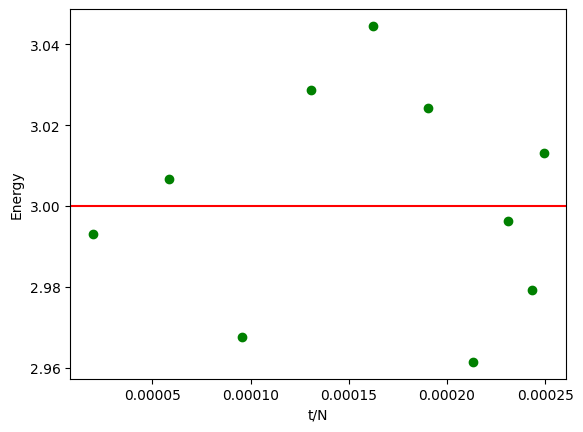

In [38]:
plt.plot(1/cheb_nodes, sample_result, 'go', label='Chebyshev nodes')
plt.axhline(y = U-t, color = 'r', linestyle = '-', label='Exact solution')
plt.xlabel('t/N')
plt.ylabel('Energy')

In [109]:
plt.plot(1/cheb_nodes,f(1/cheb_nodes))
plt.plot(1/cheb_nodes, [chebyshev_barycentric_interp(x, 10, f) for x in 1/cheb_nodes])

TypeError: only length-1 arrays can be converted to Python scalars

In [97]:
average = 0
N = 4000
u_term = scipy.linalg.expm((1j * a * time / N) * np.array([[1, 0], [0, 1]]))
t_term = scipy.linalg.expm((1j * a * time / N) * np.array([[0, -1], [-1, 0]]))
for _ in range(10):
    total = 0
    result = []
    for _ in range(N):
        choice = np.random.choice(np.array([0, 1]), p=[U/(U+t), t/(U+t)])
       
        if choice == 0:
            
            phase_result = phase_estimation(u_term, False)
            total += phase_result
            result.append(0)
        if choice == 1:
            
            phase_result = phase_estimation(t_term, True)
            total += phase_result
            result.append(1)
    average += total

In [98]:
print(average/10)

-0.8800000000001947


In [67]:
print(sample_result)

[-0.8047200025559947, -0.8296800026352816, -0.8776800027877494, -0.9290400029508458, -1.0402800033041661, -1.2268800038968635, -1.5345600048741423, -2.096160006657959, -3.436800010916648, -10.203960032411944]


In [43]:
# Checks the SAMPLE() distribution is correct
print(result.count(0))

1693


### Testing the phase estimation code

In [90]:
init_state = np.matrix([1, 0, 0, 0]).T
hd = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])
state_1 = np.dot(np.kron(hd, hd), init_state)
print(f"state_1: {state_1}")
unitary = scipy.linalg.expm(-1j * np.pi/ 1000 * np.identity(2))
# unitary = t_term
c_unitary = np.zeros((4, 4), dtype = 'complex_')
c_unitary[0, 0] = 1
c_unitary[1, 1] = 1
c_unitary[2, 2] = unitary[0, 0]
c_unitary[2, 3] = unitary[0, 1]
c_unitary[3, 2] = unitary[1, 0]
c_unitary[3, 3] = unitary[1, 1]
print(c_unitary)
state_2 = np.dot(c_unitary, state_1)
print(f"state_2: {state_2}")
state_3 = np.dot(np.kron(hd, np.identity(2)), state_2)
print(f"state_3: {state_3}")
result = np.dot((1/ np.sqrt(2)) * np.matrix([1, 1, 0, 0]), state_3)
print(result)
prob = np.linalg.norm(result)
print(prob)
print(2 * np.arccos(-prob)-2*np.pi)
print(math.degrees(2 * np.arccos(-prob))-360)

state_1: [[0.5]
 [0.5]
 [0.5]
 [0.5]]
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.99999507-0.00314159j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.99999507-0.00314159j]]
state_2: [[0.5       +0.j        ]
 [0.5       +0.j        ]
 [0.49999753-0.00157079j]
 [0.49999753-0.00157079j]]
state_3: [[7.07105036e-01-0.00111072j]
 [7.07105036e-01-0.00111072j]
 [1.74471461e-06+0.00111072j]
 [1.74471461e-06+0.00111072j]]
[[0.99999753-0.00157079j]]
0.9999987662997032
-0.0031415926540265815
-0.18000000002501793


# Exact Diagonalization

In [41]:
a = np.array([[0, 1], [0, 0]])
a_dag = np.array([[0, 0], [1, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

In [42]:
def t_term(t):
    tensor = -t * np.kron(a_dag, pauli_z) @ np.kron(np.eye(2), a)
    return tensor + np.array(tensor).conj().T

def u_term(u):
    U = np.zeros((4, 4))
    U += u * np.kron(np.eye(2), a_dag) @ np.kron(np.eye(2), a) 
    U += u * np.kron(a_dag, pauli_z) @ np.kron(a, pauli_z) 
    return U
        
def total_num_op(u):
    U = np.zeros((4, 4))
    U += u * np.kron(np.eye(2), a_dag) @ np.kron(np.eye(2), a) 
    U += u * np.kron(a_dag, pauli_z) @ np.kron(a, pauli_z) 
    return U

In [43]:
hard_core_hubbard = t_term(2) + u_term(5)

In [44]:
print(hard_core_hubbard)

[[ 0.  0.  0.  0.]
 [ 0.  5. -2.  0.]
 [ 0. -2.  5.  0.]
 [ 0.  0.  0. 10.]]


In [45]:
eigv, eigvc = scipy.linalg.eig(hard_core_hubbard)

In [46]:
print(eigv)

[ 7.+0.j  3.+0.j  0.+0.j 10.+0.j]


In [25]:
print(eigvc)

[[ 0.          0.          1.          0.        ]
 [-0.70710678  0.70710678  0.          0.        ]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          0.          1.        ]]
